In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

loading precomputed roc-auc

parse logfile

In [2]:
def parse_train_log(filename):
    with open(filename) as f:
        log_info=f.readlines()
    
    log_dict={}
    for string in log_info:
        if 'Arguments:' in string:
            
            task_name=string[string.index('experiment_name'):].split(",")[0].split(":")[-1].replace("'","").strip()
            log_dict[task_name]={'Train':{},'Validation':{},'Test':{}}
        elif string[:21]=='## Execution complete':
            log_dict[task_name]['Time']=float(string.split(' ')[-2])      
        elif string[0]=='#':
            continue        
        elif 'Train' in string or 'Validation' in string or 'Test' in string:
            string=string.strip().split(' ')
            if log_dict[task_name][string[1]].get(string[0])==None:
                log_dict[task_name][string[1]][string[0]]=[]
            if len(log_dict[task_name][string[1]][string[0]])<=int(string[-2]):
                log_dict[task_name][string[1]][string[0]].append([float(string[-1])])
            else:
                log_dict[task_name][string[1]][string[0]][int(string[-2])].append(float(string[-1]))
    for k in log_dict:
        for t in ['Train','Validation','Test']:
            for v in log_dict[k][t]:
                log_dict[k][t][v]=np.array(log_dict[k][t][v])
                if log_dict[k][t][v].dtype==object:
                    log_dict[k][t][v]=np.array([[x[-1]] for x in log_dict[k][t][v]])
    return log_dict

In [3]:
def dict_to_df(log_dict, key='loss', epoch=50, func='max'):
    d=pd.DataFrame(index=['train','val','test'])
    ke=sorted(log_dict)
    for k in ke:
        try:
            if func=='max':
                d[k]=[
                '{:.5f}'.format(log_dict[k]['Train'][key][:epoch].max()),
                '{:.5f}'.format(log_dict[k]['Validation'][key][:epoch].max()),
                '{:.5f}'.format(log_dict[k]['Test'][key][np.argmax(log_dict[k]['Validation'][key][:epoch,0])].mean())
                ]
            elif func=='mean':
                d[k]=[
                '{:.5f}'.format(log_dict[k]['Train'][key][:epoch].mean()),
                '{:.5f}'.format(log_dict[k]['Validation'][key][:epoch].mean()),
                '{:.5f}'.format(log_dict[k]['Test'][key][:epoch].mean())
                ]        
        except KeyError:
            pass
    return(d)

In [4]:
def draw_curves(ax, log_dict, keys=None, epoch=50):
    colors=['red','blue','green','orange','purple','yellow', 'magenta', 'gray','black']
    if keys==None:
        keys=log_dict[log_dict.keys()[0]]['Train']
    for i, k in enumerate(sorted(log_dict)):
        for j, v in enumerate(keys):
            try:
                ax[2*j+0].set_title('Train\n'+v.replace('complementary','pair'))
                ax[2*j+0].plot(log_dict[k]['Train'][v][:epoch], color=colors[i], alpha=1,label=k)
                ax[2*j+1].set_title('Validation\n'+v.replace('complementary','pair'))
                ax[2*j+1].plot(log_dict[k]['Validation'][v][:epoch], color=colors[i], alpha=0.6,label=k)
                #ax[1].plot(log_dict[k]['test loss'], color=colors[i], alpha=0.3,label=k+' test')
            except KeyError:
                pass
    ax[0].legend()    

In [8]:
log_dict={**parse_train_log('logs/martini_log.txt'),
          **parse_train_log('logs/martini_log1.txt'),
          **parse_train_log('logs/full_log.txt'),
          **parse_train_log('logs/from_bb_log.txt'),
          **parse_train_log('logs/no_h_log.txt')
         }

for key in list(log_dict.keys()):
    if 'no_v' in key:
        log_dict.pop(key)
    elif 'nnthr' in key:
        log_dict.pop(key)
    elif 'knn' in key:
        log_dict.pop(key)
    elif 'no_h' in key:
        a=log_dict.pop(key)
        log_dict[key.replace('no_h','heavy')]=a

        
print('Binary')
display(dict_to_df(log_dict,key='binary_AUROC', epoch=50).T)
print('Complementary')
display(dict_to_df(log_dict,key='complementary_AUROC', epoch=50).T)

Binary


/home/domain/data/prog/miniconda3/envs/dmasif_upd/lib/python3.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


,train,val,test
full_prot,0.83511,0.84565,0.80313
heavy_prot,0.84480,0.85198,0.81177
martini_prot,0.85284,0.85668,0.80928
martini_prot_from_bb,0.83162,0.83278,0.78161


Complementary


,train,val,test
full_prot,0.88215,0.89390,0.86087
heavy_prot,0.89213,0.90126,0.87030
martini_prot,0.87203,0.89127,0.86390
martini_prot_from_bb,0.85952,0.86916,0.82829


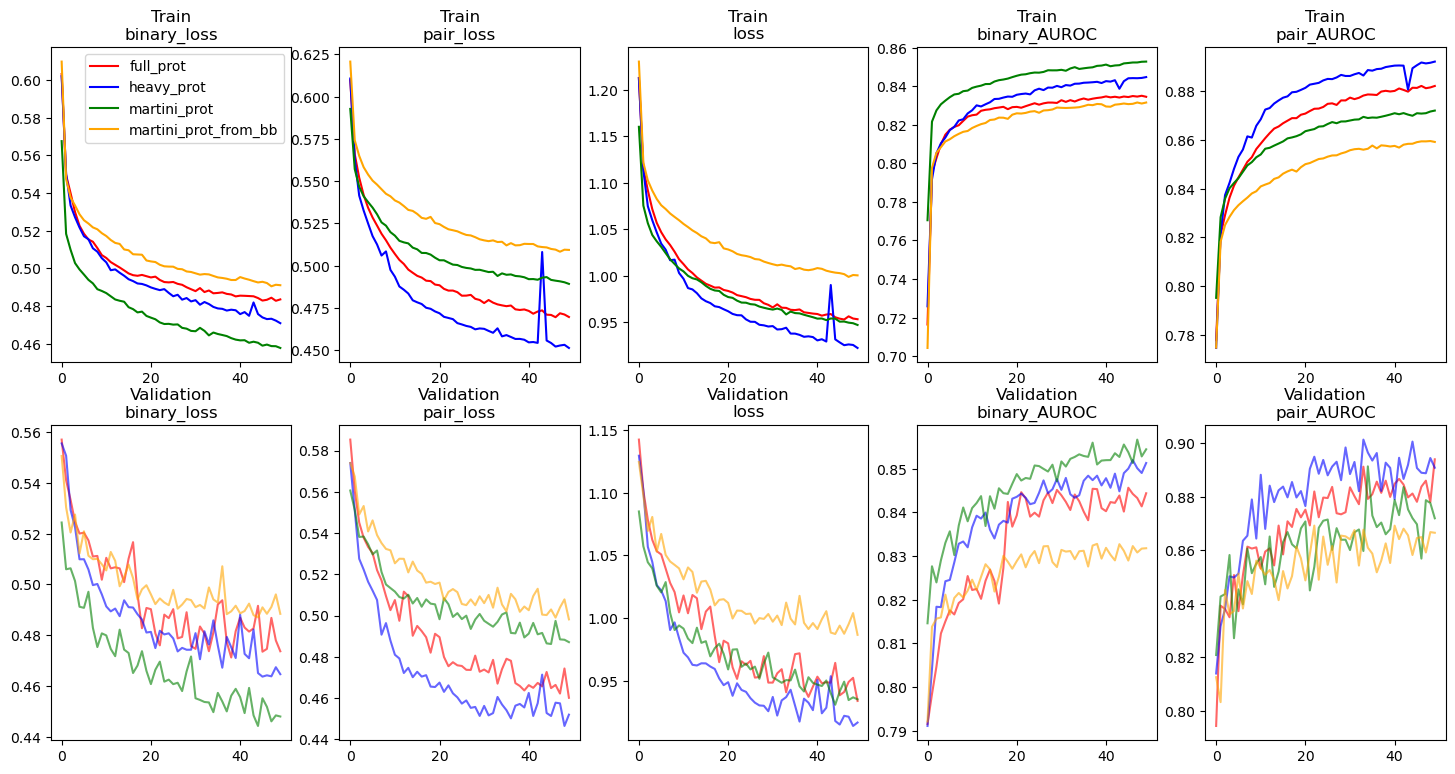

In [9]:
fig, ax=plt.subplots(2,5 , figsize=(18,9))
ax=ax.T.reshape(-1)
draw_curves(ax,log_dict, keys=['binary_loss', 
                               'complementary_loss', 
                               'loss', 
                               'binary_AUROC', 
                               'complementary_AUROC'], epoch=50)
plt.savefig('img/ppi_curves.png')

In [11]:
log_dict={**parse_train_log('logs/na_full_log.txt'),
          **parse_train_log('logs/na_no_h_log.txt'),          
          **parse_train_log('logs/na_martini_log.txt'),
          **parse_train_log('logs/na_from_bb_log.txt')}

for key in list(log_dict.keys()):
    if 'no_h' in key:
        a=log_dict.pop(key)
        log_dict[key.replace('no_h','heavy')]=a
    elif 'from_bb' in key:
        a=log_dict.pop(key)
        log_dict[key.replace('from_bb_na','martini_na_from_bb')]=a

        
print('Binary')
display(dict_to_df(log_dict,key='binary_AUROC', epoch=50).T)
print('Complementary')
display(dict_to_df(log_dict,key='complementary_AUROC', epoch=50).T)

Binary


,train,val,test
full_na,0.92243,0.92371,0.90145
heavy_na,0.93621,0.93735,0.90891
martini_na,0.93964,0.93850,0.90370
martini_na_from_bb,0.92611,0.92192,0.88086


Complementary


,train,val,test
full_na,0.91694,0.92385,0.89529
heavy_na,0.93026,0.93328,0.90704
martini_na,0.90623,0.91218,0.87815
martini_na_from_bb,0.89832,0.89603,0.86888


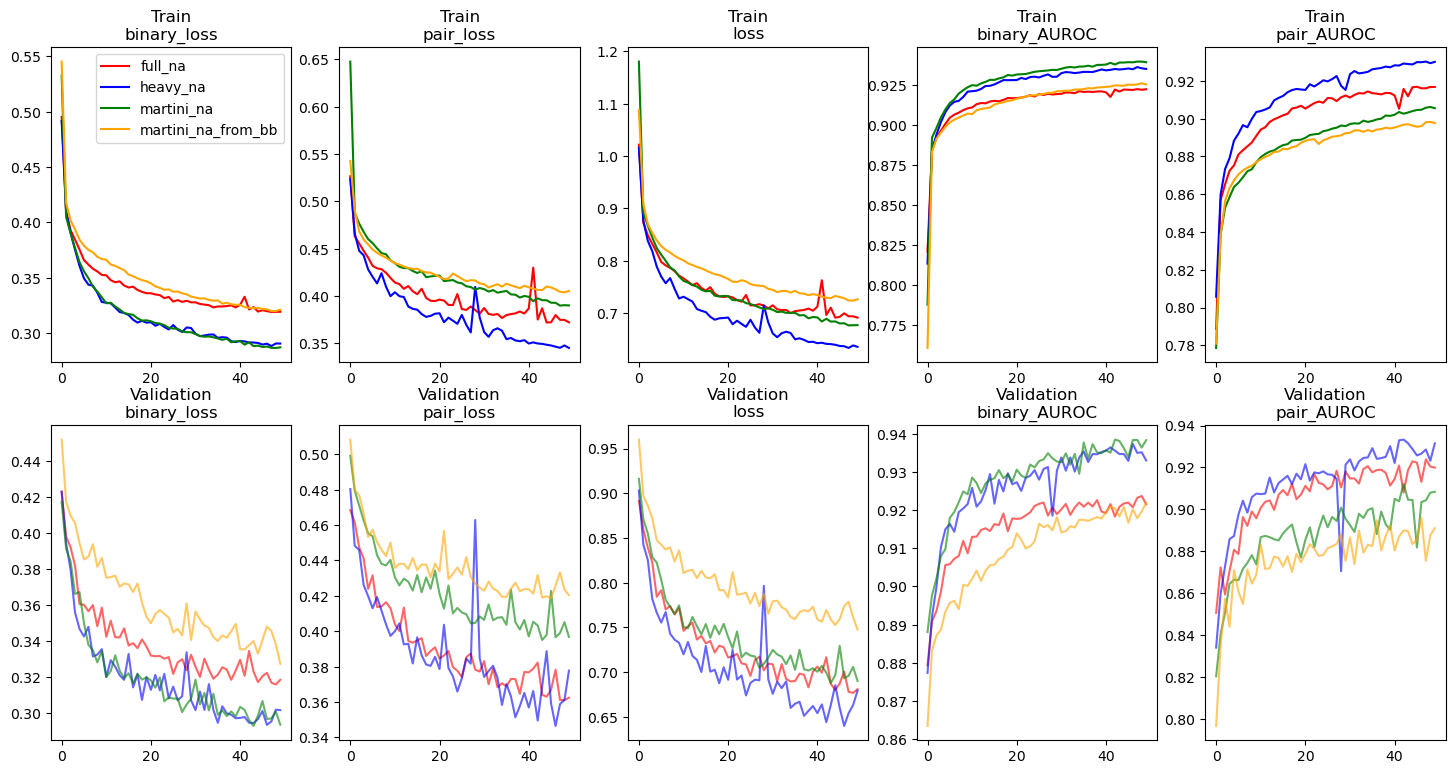

In [12]:
fig, ax=plt.subplots(2,5 , figsize=(18,9))
ax=ax.T.reshape(-1)
draw_curves(ax,log_dict, keys=['binary_loss', 
                               'complementary_loss', 
                               'loss', 
                               'binary_AUROC', 
                               'complementary_AUROC'], epoch=50)